In [268]:
import networkx
import numpy as np
from itertools import product
import numpy.ma as ma
from toolz.curried import pipe, curry
from toolz.curried import map as fmap

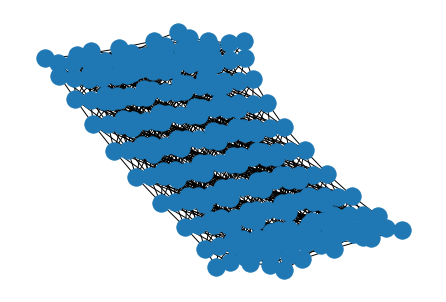

In [385]:
cond = lambda x: (x[:, 1] != -1) & (x[:, 0] != -1)

def merge_edges(neighbors, ids):
    return pipe(
        ids,
        lambda x: np.reshape(x.flatten(), (-1, 1, 1)),
        lambda x: np.repeat(x, neighbors.shape[1], axis=1),
        lambda x: np.concatenate((x, neighbors), axis=-1).reshape(-1, 2),
        lambda x: x[cond(x)],
    )

def index_vectors(nx, ny, nz):
    index2D = ([1, 0, 0], [1, 1, 0], [0, 1, 0], [-1, 1, 0])
    if ny == nz == 1:
        return ([1, 0, 0],)
    if nz == 1:
        return index2D
    else:
        return index2D + tuple([x, y, 1] for x in (1, 0, -1) for y in (1, 0, -1))

def make_ids_padded(ids):
    nx, ny, nz = ids.shape
    ids_padded = -np.ones((nx + 2, ny + 2, nz + 2), dtype=int)
    ids_padded[1:-1, 1:-1, 1:-1] = ids
    return ids_padded

@curry
def make_sub_ids(ids_padded, indices):
    nx, ny, nz = ids_padded.shape
    left, up, front = indices
    return ids_padded[1 + left:nx - 1 + left, 1 + up:ny - 1 + up, 1 + front:nz - 1 + front][..., None]

def make_neighbors(ids):
    nx, ny, nz = ids.shape
    ids_padded = make_ids_padded(ids)
    
    return pipe(
        index_vectors(nx, ny, nz),
        fmap(make_sub_ids(ids_padded)),
        list,
        lambda x: np.concatenate(x, axis=-1).reshape(nx * ny * nz, len(x), 1)
    )

def make_grid_edges(nx=1, ny=1, nz=1):
    ids = np.arange(nx * ny * nz).reshape(nx, ny, nz)
    return merge_edges(make_neighbors(ids), ids)

def make_grid_graph(shape):
    g = networkx.Graph()
    g.add_nodes_from(np.arange(np.prod(shape)))
    g.add_edges_from(make_grid_edges(*shape))
    return g

g = make_grid_graph((10, 5, 5))
networkx.draw(g)
